# Assignment 1 Applied Machine Learning

> Kypritidis Stefanos 8170050 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />

* We start by importing the libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

%matplotlib inline

matplotlib.style.use('ggplot')

pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.0f}'.format #in order to show all numbers without scientific notation

* We'll get the contributions from PAC for 2016 from https://www.fec.gov/files/bulk-downloads/2016/pas216.zip

* This includes each contribution or independent expenditure made by a PAC, party committee, candidate committee, or other federal committee to a candidate during the two-year election cycle

* We'll also need to read the header file separately, available from https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv

In [2]:
headers_contr = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv')
headers_contr

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID


This is an empty DataFrame, and only the columns are of interest to us. As a result, we'll just extract them and put them in a list.

In [3]:
headers = headers_contr.columns.tolist()
headers

['CMTE_ID',
 'AMNDT_IND',
 'RPT_TP',
 'TRANSACTION_PGI',
 'IMAGE_NUM',
 'TRANSACTION_TP',
 'ENTITY_TP',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'EMPLOYER',
 'OCCUPATION',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'CAND_ID',
 'TRAN_ID',
 'FILE_NUM',
 'MEMO_CD',
 'MEMO_TEXT',
 'SUB_ID']

* Then we have to set the datatypes of the columns by making a dictionary to specify each datatype

In [4]:
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float

* Then we can read the actual csv data file

In [5]:
contr = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/pas216.zip', 
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  dtype=data_types,
                  parse_dates=['TRANSACTION_DT'])
contr.sample(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
479720,C90011156,N,YE,G2016,201701319042165593,24E,IND,"ALLOY, NOAH",COLUMBUS,OH,432031573,NaN,NaN,10112016,99,S6OH00254,S6OH00254,VN7CZA52WC9,1144686,NaN,NaN,4020920171370125519
110113,C00458158,N,M9,P2016,201509179002687207,24K,CCM,DAVIS FOR CONGRESS,BEL AIR,MD,21014,NaN,NaN,08262015,"1,000",C00577494,H6MD04233,9393451,1025051,NaN,DIRECT CONTRIBUTION,4091720151253132446
153038,C00303339,N,YE,G2016,201701309041557858,24K,CCM,TAMMY FOR ILLINOIS,CHICAGO,IL,60610,NaN,NaN,12272016,"-2,500",C00574889,S6IL00292,C8B98F5D6DAE457991C2,1143485,NaN,NaN,4013120171369132934
44780,C00235739,N,M7,P2016,201507179000270201,24K,CCM,NOLAN FOR CONGRESS VOLUNTEER CMTE,BRAINERD,MN,56401,NaN,NaN,06172015,"2,000",C00499053,H2MN08111,B575889,1016317,NaN,NaN,4072020151247532795
49651,C00364158,N,YE,P2016,201601149004483988,24K,CCM,RYAN COSTELLO FOR CONGRESS,WEST CHESTER,PA,19381,NaN,NaN,12072015,"1,000",C00554899,H0PA06076,SB23.28640,1039594,NaN,NaN,4011420161260604219


* Having read the committees contributions file, we can read the candidates file to get the full picture of which donation goes to whom.

* Now we will need to read also the candidate master file to see which from https://www.fec.gov/files/bulk-downloads/2016/cn16.zip.

* And, as before, we'll get the corresponding header file from https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv.


In [6]:
cn_headers_df = pd.read_csv(
    'https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv')

cn_headers = cn_headers_df.columns.tolist()

* Then we read the full candidates data.

In [7]:
cn = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cn16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=cn_headers)

* Because there are all kinds of candidates, for different kinds of elections, we'll select only those running for president in the 2016 election.

* The value `'P'` for the column `CAND_OFFICE` means that the candidate runs for president.

* The value `'C'` for the column `CAND_STATUS` means 'statutory candidate'; apparently, that's what we want.

In [8]:
cn = cn.loc[(cn['CAND_ELECTION_YR'] == 2016) & (cn['CAND_OFFICE'] == 'P') & (cn['CAND_STATUS'] == 'C')]
cn.sample(5)

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
5749,P60017563,"PETERSEN, AUSTIN WADE",LIB,2016,US,P,0,O,C,C00592790,4328 WALNUT ST 3A,NaN,KANSAS CITY,MO,"64,111"
4879,P60007267,"KELSO, LLOYD THOMAS",DEM,2016,US,P,0,O,C,C00577411,3140 IVY CREEK ROAD,NaN,GASTONIA,NC,"28,056"
4486,P20002838,"HILL, CHRISTOPHER V",REP,2016,US,P,0,O,C,C00567743,9900 CORPORATE CAMPUS DR STE 3000,NaN,LOUISVILLE,KY,"40,223"
4643,P60004405,"MOOREHEAD, MONICA GAIL",UNK,2016,US,P,0,O,C,C00612275,37 BENTLEY AVENUE FLOOR 2,NaN,JERSEY CITY,NJ,"7,304"
6056,P60020963,"SOOD, AJAY",IND,2016,US,P,0,O,C,C00614727,6316 ALDEN ST,NaN,SHAWNEE,KS,"66,216"


* Now we merge all the information of contributions and candidates.

In [9]:
contr = pd.merge(contr, 
               cn[['CAND_ID', 'CAND_NAME', 'CAND_PTY_AFFILIATION']], 
               on='CAND_ID',
               how='inner')

* To make things easier, we shorten the names of the Donald Trump and Hillary Clinton

* And also we’ll prepare a subset that has contributions to the two presidential candidates campaigns only

In [10]:
contr.loc[contr['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CAND_NAME'] = 'TRUMP, DONALD J.'
contr.loc[contr['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'
contr_main = contr.loc[contr['CAND_NAME'].isin(['TRUMP, DONALD J.', 'CLINTON, HILLARY RODHAM'])].copy()
contr_main.sample(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_NAME,CAND_PTY_AFFILIATION
7831,C90011156,N,Q3,G2016,201610129032249721,24E,IND,"LEWIS, JOSHUA",CLEVELAND,OH,441152615,NaN,NaN,08052016,44,P00003392,P00003392,VN7CZA242E1,1104329,NaN,NaN,4101320161340909299,"CLINTON, HILLARY RODHAM",DEM
1421,C00401786,A,YE,G2016,201910019163581792,24A,ORG,CONSOLIDATED MAILING SERVICES,STERLING,VA,20166,NaN,NaN,10012015,"6,216",P00003392,P00003392,SE.36360,1354382,NaN,NaN,4100220191673632517,"CLINTON, HILLARY RODHAM",DEM
2409,C00004036,N,30G,G2016,201612089040554015,24E,ORG,IMAGE POINTE,WATERLOO,IA,50702,NaN,NaN,10262016,591,P00003392,P00003392,D368816,1134131,X,NaN,4010320171358297590,"CLINTON, HILLARY RODHAM",DEM
9428,C90011156,N,Q3,G2016,201610129032255242,24E,IND,"MERCADO, TIERRA",CHICAGO,IL,606362332,NaN,NaN,08312016,22,P00003392,P00003392,VN7CZA2TJW8,1104329,NaN,NaN,4101320161340925863,"CLINTON, HILLARY RODHAM",DEM
55310,C90011156,N,YE,G2016,201701319042144096,24E,IND,"OSORIO, CARLA",ORLANDO,FL,328255514,NaN,NaN,08032016,27,P00003392,P00003392,VN7CZA22XX9,1144686,NaN,NaN,4020920171370061029,"CLINTON, HILLARY RODHAM",DEM


* Firstly, we read the dates of the transactions to clear our data
* However, we see that for `TRANSACTION_DT` there is no date format
* That is why we are gonna change it into dates by using `pd.to_datetime`

In [11]:
contr_main['TRANSACTION_DT'] =  pd.to_datetime(contr_main['TRANSACTION_DT'], format='%m%d%Y')

* We clear the data so that it only includes information from 2015 and 2016

In [12]:
contr_main = contr_main.loc[(contr_main['TRANSACTION_DT'].dt.year == 2016) | \
                                        (contr_main['TRANSACTION_DT'].dt.year == 2015)]

* Now we are going to fix the table in order for it to show that each single row contribution supports the candidate name written.
* This is being done because there are many contributions that try to discredit the candidate that they have been made for
* In detail,  the value `'24A'` for the column `TRANSACTION_TP` defines an independent expenditure opposing election of candidate
* Thus, we are going to create a new column called `CAND_SUP` and for every contribution with `TRANSACTION_TP` `'24A'` we are going to fill it with the rival candidate (meaning an expenditure opposing Trump is made in favor of Clinton and the other way around).

In [13]:
contr_main['CAND_SUP'] = contr_main['CAND_NAME']
contr_main['CAND_SUP'] = np.where((contr_main['TRANSACTION_TP'] == '24A') 
               & (contr_main['CAND_NAME'] == 'CLINTON, HILLARY RODHAM') , 'TRUMP, DONALD J.',contr_main['CAND_SUP'])
contr_main['CAND_SUP'] = np.where((contr_main['TRANSACTION_TP'] == '24A') 
               & (contr_main['CAND_NAME'] == 'TRUMP, DONALD J.') , 'CLINTON, HILLARY RODHAM',contr_main['CAND_SUP'])

* Now, we will need to read also the committee master file from https://www.fec.gov/files/bulk-downloads/2016/cm16.zip in order to get the PAC names

* As before, we'll get the corresponding header file from https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv.

In [14]:
cm_headers_df =  pd.read_csv(
    'https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv')
cm_headers_df

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID


* Again, we'll extract the columns and put them in a list.

In [15]:
cm_headers = cm_headers_df.columns.tolist()

* Having the headers, we read the actual data.

In [16]:
cm = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cm16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=cm_headers)

* Now we have to clear our data

* The value `'O'` for the column `CMTE_TP` means that the committee is a super PAC

* The value `'Q'` or `'N'` for the column `CMTE_TP` means that the committee is a PAC according to  https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/

In [17]:
cm_pacs = cm.loc[(cm['CMTE_TP'] == 'O') | (cm['CMTE_TP'] == 'Q') | (cm['CMTE_TP'] == 'N')]

* We merge the contribution information with the committe information.


In [18]:
contr_pacs = pd.merge(contr_main, 
               cm_pacs[['CMTE_ID', 'CMTE_NM']], 
               on='CMTE_ID', 
               how='inner')

* Now we group the information based on each different PAC / super-PAC , getting the sum of contributions of each PAC / super-PAC
* Also we rename the columns names so that it is easier to read them

In [19]:
grouped = contr_pacs[['CMTE_ID','CMTE_NM','TRANSACTION_AMT','CAND_SUP']].groupby(['CMTE_ID','CMTE_NM','CAND_SUP']).sum().\
    sort_values(by='TRANSACTION_AMT', ascending=False)
grouped = grouped.reset_index()
grouped.rename(columns={'CMTE_ID':'Committee ID',
                          'CMTE_NM':'Committe Name',
                          'CAND_SUP':'Candidate supported',
                       'TRANSACTION_AMT': 'Transaction amount'}, 
                        inplace=True)
grouped.head(5)

,Committee ID,Committe Name,Candidate supported,Transaction amount
0,C00495861,PRIORITIES USA ACTION,"CLINTON, HILLARY RODHAM","132,517,486"
1,C00574533,FUTURE45,"TRUMP, DONALD J.","24,219,101"
2,C00618876,REBUILDING AMERICA NOW,"TRUMP, DONALD J.","21,197,098"
3,C00603621,OUR PRINCIPLES PAC,"CLINTON, HILLARY RODHAM","16,353,117"
4,C00523621,UNITED WE CAN,"CLINTON, HILLARY RODHAM","13,499,952"


#### TOP 5 PACs or super-PACs that supported Hillary Clinton contribution-wise

In [20]:
grouped.loc[grouped['Candidate supported'] == 'CLINTON, HILLARY RODHAM'][['Committe Name','Transaction amount']][:5]

,Committe Name,Transaction amount
0,PRIORITIES USA ACTION,"132,517,486"
3,OUR PRINCIPLES PAC,"16,353,117"
4,UNITED WE CAN,"13,499,952"
5,WOMEN VOTE!,"11,568,248"
6,LIFT LEADING ILLINOIS FOR TOMORROW,"9,922,027"


#### Top 5 PACs or super-PACs that supported Donald Trump  contribution-wise

In [21]:
pd.set_option('max_colwidth', 100) #increasing the column width
grouped.loc[grouped['Candidate supported'] == 'TRUMP, DONALD J.'][['Committe Name','Transaction amount']][:5]

,Committe Name,Transaction amount
1,FUTURE45,"24,219,101"
2,REBUILDING AMERICA NOW,"21,197,098"
8,NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICAL VICTORY FUND,"9,313,565"
14,RGA RIGHT DIRECTION PAC,"5,728,857"
16,MAKE AMERICA NUMBER 1,"4,376,616"


### Expenditures Analysis
* Now we will find the top PACs / super-PACs based on the money spent
* We'll get the information of committee expenditures of their campaigns from https://www.fec.gov/files/bulk-downloads/2016/weball16.zip
* We'll also need to read the header file separately, available from https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv

In [22]:
headers_exp_file = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv')
headers_exp = headers_exp_file.columns.tolist()
data_types = { header: np.str for header in headers_exp } #defining data types
data_types['TRANSACTION_AMT'] = np.float

* Then we can read the actual csv data file

In [23]:
exp = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=headers_exp,
                  dtype=data_types,
                  parse_dates=['TRANSACTION_DT'])

* Firstly, we want to organize our data. All the rows are expenditures so we are going to keep them all positive numbers

In [24]:
exp['TRANSACTION_AMT'] = exp['TRANSACTION_AMT'].abs()

* Then we filter the data by selecting only the rows with expenditures that happened in 2015 or 2016

In [25]:
exp = exp.loc[(exp['TRANSACTION_DT'].str[6:10] == '2015')| (exp['TRANSACTION_DT'].str[6:10] == '2016')]

* Now we will convert the `TRANSACTION_DΤ` in datetime type 
* We are only interested in the months because we want to group per month. As a result, we will not read the day and have all days as the 1st of the month that they belong to. 

In [26]:
exp['TRANSACTION_DT'] = pd.to_datetime(exp['TRANSACTION_DT'].str[0:2] + exp['TRANSACTION_DT'].str[6:10] ,\
                                       format='%m%Y')
exp

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID
0,C00415182,N,2015,Q1,15951142498,17,F3,SB,CHASE CARDMEMBER SERVICE,WILMINGTON,DE,198865153,2015-02-01,"3,301",P2016,CREDIT CARD PAYMENT,001,Administrative/Salary/Overhead Expenses,NaN,NaN,ORG,4041520151241882404,1002978,VN81E9TS8X8,NaN
1,C00415182,N,2015,Q1,15951142495,17,F3,SB,GOOGLE INC.,SAN FRANCISCO,CA,941390001,2015-01-01,56,P2016,INTERNET SERVICE,001,Administrative/Salary/Overhead Expenses,X,*,ORG,4041520151241882396,1002978,VN81E9TQB00,VN81E9TQAP1
2,C00415182,N,2015,Q1,15951142495,17,F3,SB,LINKEDIN CORPORATION,MOUNTAIN VIEW,CA,94043,2015-01-01,50,P2016,INTERNET SERVICE,001,Administrative/Salary/Overhead Expenses,X,*,ORG,4041520151241882397,1002978,VN81E9TQB76,VN81E9TQAP1
3,C00415182,N,2015,Q1,15951142496,17,F3,SB,NATIONBUILDER,LOS ANGELES,CA,900131155,2015-01-01,99,P2016,INTERNET SERVICE,001,Administrative/Salary/Overhead Expenses,X,*,ORG,4041520151241882398,1002978,VN81E9TS9X1,VN81E9TQAP1
4,C00415182,N,2015,Q1,15951142496,17,F3,SB,"NGP VAN, INC.",WASHINGTON,DC,20005,2015-01-01,"2,000",P2016,INTERNET SERVICE,001,Administrative/Salary/Overhead Expenses,X,*,ORG,4041520151241882399,1002978,VN81E9TQAX7,VN81E9TQAP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747278,C00000935,A,2016,YE,201708079070295371,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,2016-12-01,"7,615",NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878026,1178153,SB21B-957123,NaN
1747279,C00000935,A,2016,YE,201708079070295371,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,2016-12-01,"30,210",NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878028,1178153,SB21B-957124,NaN
1747280,C00000935,A,2016,YE,201708079070295372,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,2016-12-01,"2,549",NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878030,1178153,SB21B-957125,NaN
1747281,C00000935,A,2016,YE,201708079070295372,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,2016-12-01,"2,686",NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878032,1178153,SB21B-957126,NaN


* Now we will use the dataframe `grouped` that we have already found in order to help us know which PAC/super-PAC is supporting each presidential candidate
* We start by renaming its columns again

In [27]:
grouped.rename(columns={'Committee ID': 'CMTE_ID',
                          'Committe Name':'CMTE_NM',
                          'Candidate supported': 'CAND_SUP',
                       'Transaction amount': 'TRANSACTION_AMT'}, 
                        inplace=True)
grouped

,CMTE_ID,CMTE_NM,CAND_SUP,TRANSACTION_AMT
0,C00495861,PRIORITIES USA ACTION,"CLINTON, HILLARY RODHAM","132,517,486"
1,C00574533,FUTURE45,"TRUMP, DONALD J.","24,219,101"
2,C00618876,REBUILDING AMERICA NOW,"TRUMP, DONALD J.","21,197,098"
3,C00603621,OUR PRINCIPLES PAC,"CLINTON, HILLARY RODHAM","16,353,117"
4,C00523621,UNITED WE CAN,"CLINTON, HILLARY RODHAM","13,499,952"
...,...,...,...,...
528,C00343707,MAXIMUS INC POLITICAL ACTION COMMITTEE (MAXPAC),"CLINTON, HILLARY RODHAM",0
529,C00523225,CUMBERLAND FARMS INC POLITICAL ACTION COMMITTEE (CUMBERLAND FARMS PAC),"CLINTON, HILLARY RODHAM",0
530,C00551184,"CONTINENTAL RESOURCES, INC. POLITICAL ACTION COMMITTEE","TRUMP, DONALD J.",0
531,C00472894,ELECTING WOMEN PAC,"CLINTON, HILLARY RODHAM",0


* Now we are gonna find the duplicate values for `grouped`, meaning PACs that have supported both candidates

In [28]:
duplicate_pacs = grouped[grouped.duplicated(['CMTE_ID'])]
duplicate_pacs.head(5)

,CMTE_ID,CMTE_NM,CAND_SUP,TRANSACTION_AMT
83,C00497420,CITIZENS UNITED SUPER PAC LLC,"CLINTON, HILLARY RODHAM","112,320"
88,C00575373,MAKE AMERICA NUMBER 1,"CLINTON, HILLARY RODHAM","93,090"
91,C00618876,REBUILDING AMERICA NOW,"CLINTON, HILLARY RODHAM","81,000"
116,C00620971,FOR OUR FUTURE,"TRUMP, DONALD J.","40,420"
128,C00566174,TEA PARTY MAJORITY FUND,"CLINTON, HILLARY RODHAM","25,259"


* We will use the biggest sum of contributions by a pac to a candidate, meaning a PAC that has supported x candidate by contribuing more money to that candidate, is considered in favor of that x candidate
* We remove the duplicate PACs according to the first bullet. This happens because the `grouped` is sorted by amount of money, so the duplicate value of `CMTE_ID` is automatically the one we don't need.
* We only select positive amounts


In [29]:
grouped = grouped.drop(duplicate_pacs.index) 
grouped = grouped.loc[grouped['TRANSACTION_AMT']>0]
grouped

,CMTE_ID,CMTE_NM,CAND_SUP,TRANSACTION_AMT
0,C00495861,PRIORITIES USA ACTION,"CLINTON, HILLARY RODHAM","132,517,486"
1,C00574533,FUTURE45,"TRUMP, DONALD J.","24,219,101"
2,C00618876,REBUILDING AMERICA NOW,"TRUMP, DONALD J.","21,197,098"
3,C00603621,OUR PRINCIPLES PAC,"CLINTON, HILLARY RODHAM","16,353,117"
4,C00523621,UNITED WE CAN,"CLINTON, HILLARY RODHAM","13,499,952"
...,...,...,...,...
513,C00615088,AMERICANS UNITED FOR RESPONSIBLE LEADERSHIP,"TRUMP, DONALD J.",50
514,C00522490,PROGRESSIVES FOR PROSPERITY,"CLINTON, HILLARY RODHAM",42
515,C00614388,AMERICA'S WORKERS PAC,"CLINTON, HILLARY RODHAM",29
516,C00011338,"SAILORS' POLITICAL FUND (FKA) SAILORS' UNION OF THE PACIFIC POLITICAL FUND, DON, DON","CLINTON, HILLARY RODHAM",27


* Now we merge the tables `grouped` and `exp` (expenditures)

In [30]:
exp_grouped = pd.merge(exp, 
               grouped[['CMTE_ID', 'CMTE_NM','CAND_SUP']], 
               on='CMTE_ID',
               how='inner')
exp_grouped.head(5)

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID,CMTE_NM,CAND_SUP
0,C00581504,A,2015,Q3,201601150200001803,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,40,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034094,1042987,SB0127161803174,NaN,RESTORING AMERICAN LEADERSHIP PAC,"TRUMP, DONALD J."
1,C00581504,A,2015,Q3,201601150200001802,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,32,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034091,1042987,SB0127161802171,NaN,RESTORING AMERICAN LEADERSHIP PAC,"TRUMP, DONALD J."
2,C00581504,A,2015,Q3,201601150200001802,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,20,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034092,1042987,SB0127161802172,NaN,RESTORING AMERICAN LEADERSHIP PAC,"TRUMP, DONALD J."
3,C00581504,A,2015,Q3,201601150200001803,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,4,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034093,1042987,SB0127161803173,NaN,RESTORING AMERICAN LEADERSHIP PAC,"TRUMP, DONALD J."
4,C00581504,A,2015,Q3,201601150200001798,17,F3,SB,APEX,BEVERLY,MA,01915,2015-08-01,100,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034080,1042987,SB0127161798160,NaN,RESTORING AMERICAN LEADERSHIP PAC,"TRUMP, DONALD J."


* Now we group the information based on each different PAC / super-PAC , getting the sum of expenditures of each PAC / super-PAC

In [31]:
grouped_exp = exp_grouped[['CMTE_ID','CMTE_NM','TRANSACTION_AMT','CAND_SUP']].groupby(['CMTE_ID','CMTE_NM','CAND_SUP']).sum().\
    sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp = grouped_exp.reset_index()
grouped_exp[['CMTE_NM','CAND_SUP','TRANSACTION_AMT']][:10]

,CMTE_NM,CAND_SUP,TRANSACTION_AMT
0,PRIORITIES USA ACTION,"CLINTON, HILLARY RODHAM","89,086,896"
1,CONSERVATIVE SOLUTIONS PAC,"CLINTON, HILLARY RODHAM","46,148,469"
2,NEXTGEN CLIMATE ACTION COMMITTEE,"CLINTON, HILLARY RODHAM","42,374,717"
3,EMILY'S LIST,"CLINTON, HILLARY RODHAM","39,455,965"
4,RIGHT TO RISE USA,"CLINTON, HILLARY RODHAM","30,139,862"
5,AMERICAN BRIDGE 21ST CENTURY,"CLINTON, HILLARY RODHAM","28,443,333"
6,HOUSE MAJORITY PAC,"CLINTON, HILLARY RODHAM","26,450,386"
7,SENATE MAJORITY PAC,"CLINTON, HILLARY RODHAM","23,722,432"
8,FOR OUR FUTURE,"CLINTON, HILLARY RODHAM","17,805,516"
9,WORKING AMERICA COALITION,"CLINTON, HILLARY RODHAM","15,290,980"


####  Top 5 PACs or super-PACs that supported Hillary Clinton expenditure-wise

In [32]:
grouped_exp.loc[grouped_exp['CAND_SUP'] == 'CLINTON, HILLARY RODHAM'][['CMTE_NM','TRANSACTION_AMT']][:5]

,CMTE_NM,TRANSACTION_AMT
0,PRIORITIES USA ACTION,"89,086,896"
1,CONSERVATIVE SOLUTIONS PAC,"46,148,469"
2,NEXTGEN CLIMATE ACTION COMMITTEE,"42,374,717"
3,EMILY'S LIST,"39,455,965"
4,RIGHT TO RISE USA,"30,139,862"


#### Top 5 PACs or super-PACs that supported Donald Trump expenditure-wise

In [33]:
grouped_exp.loc[grouped_exp['CAND_SUP'] == 'TRUMP, DONALD J.'][['CMTE_NM','TRANSACTION_AMT']][:5]

,CMTE_NM,TRANSACTION_AMT
14,THE 2016 COMMITTEE,"8,777,660"
18,NATIONAL CAMPAIGN,"5,660,049"
20,AMERICAN CROSSROADS,"5,054,430"
21,VIGOP (VIRGIN ISLANDS REPUBLICAN PARTY),"3,717,870"
22,REBUILDING AMERICA NOW,"3,246,121"


## Question 2

* We'll get the contributions from individuals for 2016 from https://www.fec.gov/files/bulk-downloads/2016/indiv16.zip. Download the file and extract it in the folder 'indiv16' which should be placed in the same folder as this notebook

* This includes contributor names, occupation and employer, address, and contribution amount.

* We'll also need to read the header file separately, available from https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv.
* We create a list with the headings and then a dictionary with the data types we want for the DataFrame

In [34]:
headers_df = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv')
headers = headers_df.columns.tolist()
data_types = { header: np.str for header in headers }
data_types['TRANSACTION_AMT'] = np.float

* And here we go with the full data.

In [35]:
fec_data = pd.read_csv('indiv16/itcont.txt',
                  sep="|", 
                  index_col=False, 
                  names=headers,
                  dtype=data_types)

* Now we need to clear our data
* We decide to consider only amounts over 100 dollars when it comes to `TRANSACTION_AMT` because of the huge amount of contributions. The logic is that the biggest contributors would probably not make hundreds of small amount contributions (the commands would not work in my laptop if we didn't do that step)

In [36]:
fec_data = fec_data.loc[fec_data['TRANSACTION_AMT'] > 100]

* The value `'IND'` for the column `ENTITY_TP` means that the contribution was made by an individual
* The value `'CAN'` for the column `ENTITY_TP` means that the contribution was made by a candidate which is considered to be an individual as well

In [37]:
fec_data = fec_data.loc[(fec_data['ENTITY_TP'] == 'IND') | (fec_data['ENTITY_TP'] == 'CAN')]

* Also we will only select transactions that are contributions to a committe or PAC or super-PAC 
* As a result we will pick the value `'15'`, `'15E'`, `'10'` or `'15C'` for the column `TRANSACTION_TP`, which are contributions
* Also we will keep the value `'24T'` for the column `TRANSACTION_TP` because it concerns contribution passed to the recepient. We will multiply this amount with (-1) so that when we sum it up it gets substructed.
* We can see all the information of transaction types in detail at https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/

In [38]:
fec_data = fec_data.loc[(fec_data['TRANSACTION_TP'] == '15') | (fec_data['TRANSACTION_TP'] == '15E') | \
            (fec_data['TRANSACTION_TP'] == '10') | (fec_data['TRANSACTION_TP'] == '15C') |
            (fec_data['TRANSACTION_TP'] == '24T') ]

fec_data['TRANSACTION_AMT'] = np.where((fec_data['TRANSACTION_TP'] == '24T'), 
                fec_data['TRANSACTION_AMT'] * (-1), fec_data['TRANSACTION_AMT'])

* Now we have to fix our data
* We are gonna check each of the names with the top contributions. In detail, we will count the values of the same name but with some variations of it being written. Then we will use a dictionary to get the same name for every different variation of every different name
* For example the name `'STEYER, THOMAS F.'` is also written as `'STEYER, THOMAS'` , `'STEYER, THOMAS F'` etc. We will change all of those to `'STEYER, THOMAS'`

In [39]:
(fec_data.loc[fec_data['NAME'].str.contains('STEYER')])['NAME'].value_counts()

STEYER, THOMAS         96
STEYER, MARGARET       35
STEYER, THOMAS F.      23
STEYER, TOM            17
STEYER, ALLAN          14
STEYER, SAMUEL          8
STEYER, THOMAS FAHR     7
STEYER, THOMAS F        5
STEYER, EVELYN          3
GASTEYER, ANA           3
STEYER, RACHEL          3
STEYER, HUME            2
GASTEYER, TED II        2
STEYER, HUME R          2
STEYER, ALAN            1
GASTEYER, PHIL          1
STEYER, CHARLES         1
STEYER, STEYER          1
STEYER, MICHELLE        1
STEYER, HENRY           1
STEYER, KATHRYN ANN     1
Name: NAME, dtype: int64

* We do the same for all the names and as a result we create this dictionary

In [40]:
names_mapping = {
    'STEYER, THOMAS F.' : 'STEYER, THOMAS',
    'STEYER, THOMAS F' : 'STEYER, THOMAS',
    'STEYER, THOMAS FAHR' : 'STEYER, THOMAS',
    'EYCHANER, FRED MR.' : 'EYCHANER, FRED',
    'ADELSON, SHELDON G' : 'ADELSON, SHELDON',
    'ADELSON, MIRIAM DR.' : 'ADELSON, MIRIAM',
    'ADELSON, SHELDON G MR' : 'ADELSON, SHELDON',
    'ADELSON, SHELLEY' : 'ADELSON, SHELDON',
    'ADELSON, MIRIAM DR' : 'ADELSON, MIRIAM',
    'ADELSON, SHELDON G. MR.' : 'ADELSON, SHELDON',
    'ADELSON, MIRIAM O.' : 'ADELSON, MIRIAM',
    'SUSSMAN, S. DONALD' : 'SUSSMAN, DONALD',
    'SUSSMAN, S DONALD' : 'SUSSMAN, DONALD',
    'SUSSMAN, S. D.' : 'SUSSMAN, DONALD',
    'BLOOMBERG, MICHAEL R' : 'BLOOMBERG, MICHAEL',
    'BLOOMBERG, MICHAEL R.' : 'BLOOMBERG, MICHAEL',
    'BLOOMBERG, MICHAEL MR' : 'BLOOMBERG, MICHAEL',
    'RICKETTS, MARLENE M.' : 'RICKETTS, MARLENE',
    'NEUGEBAUER, TOBY MR.' : 'NEUGEBAUER, TOBY',
    'MERCER, ROBERT L.' : 'MERCER, ROBERT',
    'MERCER, ROBERT MR.' : 'MERCER, ROBERT',
    'MERCER, ROBERT L' : 'MERCER, ROBERT',
    'MERCER, ROBERT LEROY MR.' : 'MERCER, ROBERT',
    'MOSKOVITZ, DUSTIN A.' : 'MOSKOVITZ, DUSTIN',
    'MARCUS, BERNARD MR' : 'MARCUS, BERNARD',
    'MARCUS, BERNARD MR.' : 'MARCUS, BERNARD',
    'UIHLEIN, RICHARD E.' : 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD E' : 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD E. MR.' : 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD MR' : 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD E MR.' : 'UIHLEIN, RICHARD',
    'UIHLEIN, RICHARD MR.' : 'UIHLEIN, RICHARD',
    'SIMONS, JAMES H.' : 'SIMONS, JAMES',
    'SIMONS, JAMES HARRIS' : 'SIMONS, JAMES',
    'SIMONS, JAMES H' : 'SIMONS, JAMES',
    'WARREN, KELCY L.' : 'WARREN, KELCY L',
    'WARREN, KELCY L MS.' : 'WARREN, KELCY L',
    'PRITZKER, JAY ROBERT' : 'PRITZKER, JAY',
    'DEASON, DARWIN MR.' : 'DEASON, DARWIN',
    'DEASON, DARWIN MR' : 'DEASON, DARWIN',
    'SINGER, PAUL MR.' : 'SINGER, PAUL',
    'SINGER, PAUL E.' : 'SINGER, PAUL',
    'SINGER, PAUL E. MR.' : 'SINGER, PAUL',
    'SINGER, PAUL E MR' : 'SINGER, PAUL',
    'ABRAHAM, DANIEL J' : 'ABRAHAM, DANIEL',
    'TRUMP, DONALD J.' : 'TRUMP, DONALD J',
    'TRUMP, DONALD J J.' : 'TRUMP, DONALD J'
    
}

# If no mapping provided, return x
f = lambda x: names_mapping.get(x, x) 
fec_data.loc[:, 'NAME'] = fec_data.loc[:, 'NAME'].map(f)

* Now we will clear our data from any contributions that happened outside of 2015 and 2016



In [41]:
fec_data = fec_data.loc[(fec_data['TRANSACTION_DT'].str[4:8] == '2015') | \
                        (fec_data['TRANSACTION_DT'].str[4:8] == '2016')]

* Now, we read `TRANSACTION_DT` and transform it into datetime

In [42]:
fec_data['TRANSACTION_DT'] =  pd.to_datetime(fec_data['TRANSACTION_DT'], format='%m%d%Y')

* We have already read the committe master files from question one 
* Now we want  the value `'O'`, `'Q'`, `'N'`, `'I'` or `'P'` for the column `CMTE_TP` meaning we look for PACs, committees or super PACs
* More information at  https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/


In [43]:
cm_cont = cm.loc[(cm['CMTE_TP'] == 'O') | (cm['CMTE_TP'] == 'Q') | (cm['CMTE_TP'] == 'N') |
                (cm['CMTE_TP'] == 'I') | (cm['CMTE_TP'] == 'P')]

* We merge the tables `fec_data` and `cm_cont` in order to see contributions made to a PAC, super-PAC or committe

In [44]:
fec_data = pd.merge(fec_data, 
               cm_cont[['CMTE_ID','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')
fec_data.sample(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID
789311,C00450056,N,YE,NaN,201601279004623984,15,IND,"CONSTANTINE, JOHN J.",E FALLOWFIELD,PA,19320,INDEPENDENCE BLUE CROSS,MGR APPLICATION MAINTENCE SVCS,2015-12-26,130,NaN,C3227082,1042693,NaN,* PAYROLL DEDUCTION: BI-WEEKLY $10,4012720161260957686,NaN
2163102,C00618371,A,12G,P,201702219050479583,15,IND,"CASTRORAO, ERNEST W.",NORTH PLAINFIELD,NJ,07063,PENN JERSEY PAINT G.,ENGINEER,2016-10-07,105,NaN,SA11AI.1618582,1150559,NaN,NaN,4022220171371983652,NaN
1142700,C00193433,N,M3,NaN,201603169009762513,15,IND,"RICHARDS, LOIS C. MS.",SPOKANE,WA,99212,NOT-EMPLOYED,RETIRED,2016-02-05,125,NaN,4508644,1055557,NaN,NaN,4031720161276473943,NaN
1624932,C00373696,N,M6,P,201606209018482326,15,IND,"CERTA, KENNETH MICHAEL MD",PHILADELPHIA,PA,191074405,SELF EMPLOYED,PHYSICIAN,2016-05-14,"1,000",NaN,C3335785,1078926,NaN,NaN,4062120161299918679,NaN
670406,C00117424,N,YE,P,201701319042238092,15,IND,"DICKSON, WARD H",NORCROSS,GA,30071,WESTROCK,EVP & CFO,2016-11-30,380,NaN,SA11AI.16504,1145369,NaN,NaN,4020720171369910924,NaN


* We join the tables `fec_data` and `grouped` (from question 1) in order to know exactly which candidate each individual supports . Those contributions only concern PACs and super-PACs as calculated in question 1

In [45]:
fec_data = pd.merge(fec_data, 
               grouped[['CMTE_ID', 'CAND_SUP']], 
               on='CMTE_ID', 
               how='left')
fec_data.sample(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_SUP
493339,C00186288,A,YE,NaN,201603209011684399,15,IND,"HENZE, KATRINA A.",FAR HILLS,NJ,079312602,CELLCO PARTNERSHIP,AREA VP-MARKETING,2015-12-18,153,NaN,W20151216-205-7-47,1056816,NaN,NaN,4032120161276577774,NaN,NaN
1490187,C00577130,A,YE,P2016,201606159017932889,15,IND,"HARMON, CHRIS",NORMAN,OK,730712003,MIDFIRST BANK,DATABASE ADMINISTRATOR,2015-10-15,250,NaN,VPF7BGG9RB7,1077572,NaN,NaN,4061720161299438220,P60007168,NaN
147078,C00494476,N,Q2,P,201507159000146651,15,IND,"HOLZMAN, STEVEN D",KETCHUM,ID,83340,VANTIS CAPITAL MANAGEMENT,MANAGING PARTNER,2015-04-29,"10,000",NaN,SA11AI.5873,1015000,NaN,NaN,4071520151247110880,H8WI01024,NaN
1087180,C00575795,A,M6,P2016,201607309022022767,15,IND,"SHAPIRO, IAN",NEW YORK,NY,100256502,COOLEY,LAWYER,2016-05-13,"1,000",NaN,C4992970,1091720,NaN,NaN,4080320161308107365,P00003392,NaN
158268,C00399386,N,M7,P,201607149020446309,15,IND,"BARNEY, ROBIN",WARSAW,IN,46580,"ZIMMER BIOMET HOLDINGS, INC.",GLBL OPS & LOGISTICS SVP,2016-06-17,190,NaN,SA11AI.10400,1084003,NaN,NaN,4071420161306620654,NaN,NaN


* We merge the data of individual contributions and candidate master (for contributions from individuals)

In [46]:
fec_data = pd.merge(fec_data, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='left')
fec_data.sample(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_SUP,CAND_NAME
1986893,C00586537,A,Q3,P,201708319071256089,15,IND,"DEWALD, PACIA",DALY CITY,CA,940152440,UNITED AIRLINES,CUSTOMER SERVICE REPRESENTATIVE,2016-08-04,401,NaN,C8309846,1180866,NaN,NaN,4090120171448336498,NaN,NaN,NaN
1528963,C00577130,A,M3,P2016,201606169018224261,15,IND,"CARNEY, JAMES N.",BENTONVILLE,AR,727128716,NaN,NaN,2016-02-02,"2,700",NaN,VPF7BKQ51A7,1077916,NaN,NaN,4063020161300622023,P60007168,NaN,"SANDERS, BERNARD"
344105,C00144170,N,MY,P,201507299000443359,15,IND,"FRIEDMAN, REUBEN",NEW ORLEANS,LA,70124,NaN,RETIRED,2015-04-22,400,NaN,SA11AI.5783,1018644,NaN,NaN,4072920151248004030,NaN,NaN,NaN
206233,C00012914,N,M4,P,201604159012467386,15,IND,"REILLY, KEVIN J.",NEW YORK,NY,100173144,FIRST AMERICAN TITLE INSURANCE COMPANY,REGIONAL MANAGER,2016-03-22,250,NaN,5F5C695BE824B543804,1063288,NaN,NaN,4042020161283564553,NaN,NaN,NaN
1956677,C00586537,A,Q3,P,201708319071272183,15,IND,"DEMARIA, JOHN",SPRING LAKE,MI,494569514,NaN,RETIRED,2016-07-30,729,NaN,C8042858,1180866,NaN,NaN,4090120171448384781,NaN,NaN,NaN


* We fix the names of candidates for the column `CAND_NAME`

In [47]:
fec_data.loc[fec_data['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CAND_NAME'] = 'TRUMP, DONALD J.'
fec_data.loc[fec_data['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'


* We clear the data from non relevant candidates

In [48]:
fec_data = fec_data.loc[(fec_data['CAND_SUP'].notna()) | (fec_data['CAND_NAME'].notna())] #for null candidates supported
fec_data = fec_data.loc[(fec_data['CAND_NAME'].isna()) | (fec_data['CAND_NAME'] == 'TRUMP, DONALD J.')\
                    | (fec_data['CAND_NAME'] == 'CLINTON, HILLARY RODHAM')]#for candidares other than clinton and trump

* We update the data of  the column `CAND_SUP` so that we know exactly which candidate is supported by every contribution
* Specifically, we copy and paste the value of `CAND_NAME` wherever `CAND_SUPP` is null

In [49]:
fec_data['CAND_SUP'] = np.where( fec_data['CAND_SUP'].isna(), fec_data['CAND_NAME'], fec_data['CAND_SUP'])

* We create another dataframe called `grouped2` in order to have all the information grouped per name of contributor and candidate that is supported

In [50]:
grouped2 = fec_data[['NAME','TRANSACTION_AMT','CAND_SUP']].loc[fec_data['CAND_SUP'].notna()].\
         groupby(['NAME','CAND_SUP']).sum().\
         sort_values(by='TRANSACTION_AMT', ascending=False)
grouped2 = grouped2.reset_index()

#### TOP individuals that supported Hillary Clinton 

In [51]:
grouped2.loc[grouped2['CAND_SUP'] =='CLINTON, HILLARY RODHAM'][['NAME', 'TRANSACTION_AMT']][:11]

,NAME,TRANSACTION_AMT
0,"STEYER, THOMAS","89,465,200"
1,"SUSSMAN, DONALD","37,002,700"
2,"EYCHANER, FRED","35,265,400"
3,"BLOOMBERG, MICHAEL","22,705,089"
4,"SIMONS, JAMES","22,015,000"
5,"SOROS, GEORGE","19,712,393"
8,"MOSKOVITZ, DUSTIN","14,625,000"
9,"ASSOCIATION, NATIONAL EDUCATION","12,175,000"
12,"PRITZKER, JAY","9,650,848"
13,"ABRAHAM, DANIEL","9,250,000"


Note: ASSOCIATION, NATIONAL EDUCATION is not an individual in reality but according to our data it has the value `IND` for `ENTITY_TP` so it is considered an individual

#### TOP individuals that supported Donald Trump

In [52]:
grouped2.loc[grouped2['CAND_SUP'] =='TRUMP, DONALD J.'][['NAME', 'TRANSACTION_AMT']][:10]

,NAME,TRANSACTION_AMT
6,"TRUMP, DONALD J","18,633,157"
7,"MERCER, ROBERT","15,500,000"
10,"ADELSON, SHELDON","10,000,000"
11,"ADELSON, MIRIAM","10,000,000"
14,"HENDRICKS, DIANE","8,061,900"
18,"MCMAHON, LINDA E.","7,000,000"
19,"MARCUS, BERNARD","7,000,000"
21,"UIHLEIN, RICHARD","6,939,200"
35,"PALMER, GEOFFREY H.","4,000,000"
36,"HENDRICKS, DIANE MS.","4,000,000"


## Question 3

* Firstly we will get the contributions `contr_main` from question 1 as we have already cleared the data to include the candidate that is supported from every contribution
* We copy `contr_main` to another dataframe
* Those contributions do not include individual contributions though

In [53]:
contr_main_q3 = contr_main.copy()

* As we are only interested in the year and the month, we cut the additional information of  each date 
* We use `dt.to_period('M')` to do so

In [54]:
contr_main_q3['TRANSACTION_DT'] = contr_main_q3['TRANSACTION_DT'].dt.to_period('M')

* Now, we can use `pivot_table` to aggregate the data by date and candidate

In [55]:
contr_by_dates = contr_main_q3.pivot_table(index='TRANSACTION_DT', 
                                     columns='CAND_SUP',
                                     values='TRANSACTION_AMT',
                                     aggfunc='sum')
contr_by_dates

CAND_SUP,"CLINTON, HILLARY RODHAM","TRUMP, DONALD J."
TRANSACTION_DT,,
2015-01,nan,661
2015-02,nan,250
2015-03,nan,"42,800"
2015-04,"56,963","115,122"
2015-05,"49,737","284,207"
2015-06,"245,183","930,056"
2015-07,"95,363","424,498"
2015-08,"337,027","219,567"
2015-09,"1,218,962","195,199"


* We change the index (first column) so that the months are written by names and not by number
* This will make the observation of the plot much easier.

In [56]:
contr_by_dates.index = contr_by_dates.index.strftime('%b-%Y')

* Now we are going to find and group the individual contributions to candidates by using `fec_data` from question 2

In [57]:
fec_data.head(5)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_SUP,CAND_NAME
28685,C00072967,N,M3,NaN,15950888506,15,IND,"KEMPER, DAVID W.",ST. LOUIS,MO,63124,"COMMERCE BANCSHARES, INC.",CHAIRMAN & CEO,2015-02-26,125,NaN,SA11AI.4912,998886,NaN,NaN,4032020151240888616,NaN,"CLINTON, HILLARY RODHAM",NaN
28686,C00072967,N,M8,NaN,201508119000813845,15,IND,"KEMPER, DAVID W.",ST. LOUIS,MO,63124,"COMMERCE BANCSHARES, INC.",CHAIRMAN & CEO,2015-07-17,125,NaN,SA11AI.5175,1021297,NaN,NaN,4081120151248540441,NaN,"CLINTON, HILLARY RODHAM",NaN
28687,C00072967,N,M7,NaN,201507099000071217,15,IND,"KEMPER, DAVID W.",ST. LOUIS,MO,63124,"COMMERCE BANCSHARES, INC.",CHAIRMAN & CEO,2015-06-25,125,NaN,SA11AI.5124,1013033,NaN,NaN,4070920151246161913,NaN,"CLINTON, HILLARY RODHAM",NaN
28688,C00072967,N,M5,NaN,15970689188,15,IND,"KEMPER, DAVID W.",ST. LOUIS,MO,63124,"COMMERCE BANCSHARES, INC.",CHAIRMAN & CEO,2015-04-28,125,NaN,SA11AI.5006,1006891,NaN,NaN,4050620151243241717,NaN,"CLINTON, HILLARY RODHAM",NaN
28689,C00072967,N,M6,NaN,15971204182,15,IND,"KEMPER, DAVID W.",ST. LOUIS,MO,63124,"COMMERCE BANCSHARES, INC.",CHAIRMAN & CEO,2015-05-27,125,NaN,SA11AI.5063,1010191,NaN,NaN,4061120151245679956,NaN,"CLINTON, HILLARY RODHAM",NaN


 * As we are only interested in the year and the month, we cut the additional information of  each date by using `dt.to_period('M')` to do so

In [58]:
fec_data['TRANSACTION_DT'] = fec_data['TRANSACTION_DT'].dt.to_period('M')

* Now, we can use `pivot_table` to aggregate the data by date and candidate

In [59]:
ind_contr_by_dates = fec_data.pivot_table(index='TRANSACTION_DT', 
                                     columns='CAND_SUP',
                                     values='TRANSACTION_AMT',
                                     aggfunc='sum')
ind_contr_by_dates

CAND_SUP,"CLINTON, HILLARY RODHAM","TRUMP, DONALD J."
TRANSACTION_DT,,
2015-01,"22,064,580","242,792"
2015-02,"23,085,483","351,678"
2015-03,"21,778,316","375,843"
2015-04,"28,107,060","12,783,965"
2015-05,"33,069,081","624,345"
2015-06,"52,138,711","1,054,192"
2015-07,"11,964,339","2,428,345"
2015-08,"11,726,812","1,969,610"
2015-09,"16,352,926","2,351,345"


* We change the index (first column) so that the months are written by names and not by number

In [60]:
ind_contr_by_dates.index = ind_contr_by_dates.index.strftime('%b-%Y')

* Now we merge the two dataframes we have found that concern contributions 

In [61]:
contr_by_dates = pd.merge(contr_by_dates, 
               ind_contr_by_dates, 
               on='TRANSACTION_DT',
               how='left')

* We fill none values with 0 in order to do the addition of the two columns

In [62]:
contr_by_dates['CLINTON, HILLARY RODHAM_x'] = contr_by_dates['CLINTON, HILLARY RODHAM_x'].fillna(0)

* Now we add the two columns of each candidate and our dataframe is ready

In [63]:
contr_by_dates ['CLINTON, HILLARY RODHAM'] = contr_by_dates ['CLINTON, HILLARY RODHAM_x'] +\
        contr_by_dates ['CLINTON, HILLARY RODHAM_y']
contr_by_dates ['TRUMP, DONALD J.'] = contr_by_dates ['TRUMP, DONALD J._x'] +\
        contr_by_dates ['TRUMP, DONALD J._y']
contr_by_dates = contr_by_dates[['CLINTON, HILLARY RODHAM','TRUMP, DONALD J.']]

* We can observe the results very easily with the use of a bar plot 

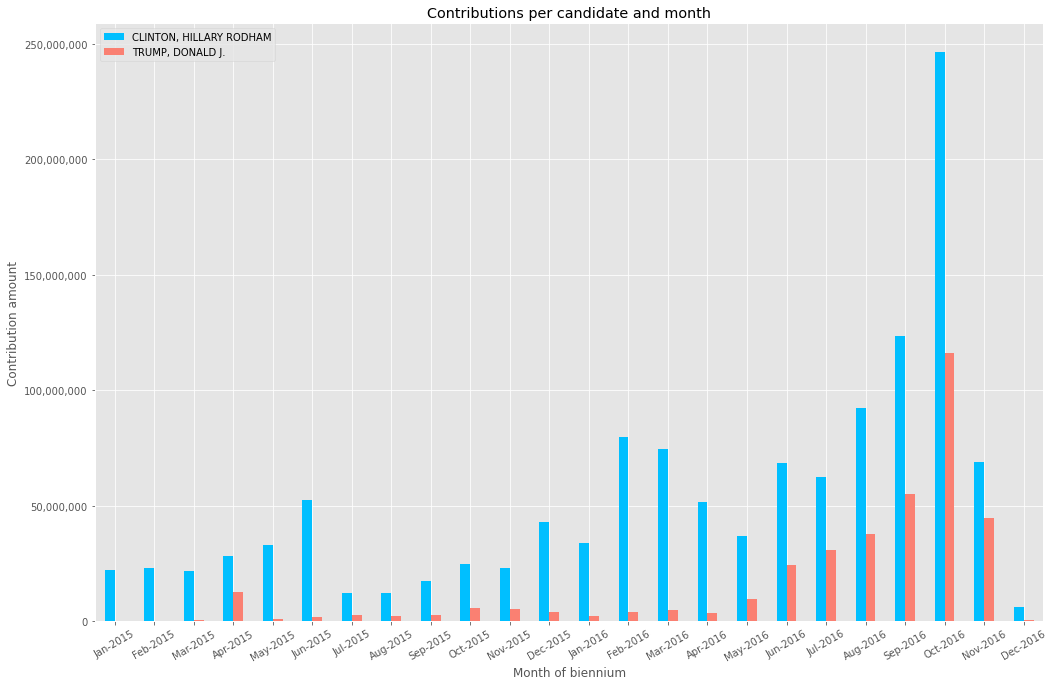

In [64]:
ax = contr_by_dates.plot(kind='bar', color=('deepskyblue', 'salmon'), figsize=(17, 11))
plt.title('Contributions per candidate and month')
plt.xlabel('Month of biennium')
plt.ylabel('Contribution amount')
plt.xticks(rotation=30, horizontalalignment="center") #rotation of x axis names
plt.legend(loc=2)
plt.ticklabel_format(style='plain', axis='y') #in order to show the y axis values as non scientific notations
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))) 
#adds commas to the y axis values to make them easier to read

### Expenditures analysis

* We have the whole expenditures dataframe saved and cleared from question 1 as `exp`

* Now we will group the `fec_data` in order to see which candidate is supported by the contributions of each committee.

In [65]:
unique_fec_data = fec_data[['CMTE_ID','TRANSACTION_AMT','CAND_SUP']].\
         groupby(['CMTE_ID','CAND_SUP']).sum().\
         sort_values(by='TRANSACTION_AMT', ascending=False)
unique_fec_data = unique_fec_data.reset_index()

* Now we will merge the information of the expenditures with `unique_fec_data` in order to know which expenditure corresponds to each candidate's campaign

In [66]:
exp = pd.merge(exp, 
               unique_fec_data[['CMTE_ID', 'CAND_SUP']], 
               on='CMTE_ID',
               how='inner')
exp.head(5)

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID,CAND_SUP
0,C00581504,A,2015,Q3,201601150200001803,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,40,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034094,1042987,SB0127161803174,NaN,"TRUMP, DONALD J."
1,C00581504,A,2015,Q3,201601150200001802,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,32,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034091,1042987,SB0127161802171,NaN,"TRUMP, DONALD J."
2,C00581504,A,2015,Q3,201601150200001802,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,20,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034092,1042987,SB0127161802172,NaN,"TRUMP, DONALD J."
3,C00581504,A,2015,Q3,201601150200001803,17,F3,SB,APEX,BEVERLY,MA,01915,2015-09-01,4,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034093,1042987,SB0127161803173,NaN,"TRUMP, DONALD J."
4,C00581504,A,2015,Q3,201601150200001798,17,F3,SB,APEX,BEVERLY,MA,01915,2015-08-01,100,P,MERCHANT FEES,NaN,NaN,NaN,NaN,NaN,2012720161261034080,1042987,SB0127161798160,NaN,"TRUMP, DONALD J."


* Now, we can use `pivot_table` to aggregate the data by date and candidate.

In [67]:
exp_by_dates = exp.pivot_table(index='TRANSACTION_DT', 
                                     columns='CAND_SUP',
                                     values='TRANSACTION_AMT',
                                     aggfunc='sum')
exp_by_dates

CAND_SUP,"CLINTON, HILLARY RODHAM","TRUMP, DONALD J."
TRANSACTION_DT,,
2015-01-01,"4,536,377","1,699,926"
2015-02-01,"4,834,339","2,103,981"
2015-03-01,"7,146,672","2,474,151"
2015-04-01,"9,955,901","2,764,276"
2015-05-01,"14,845,399","2,657,465"
2015-06-01,"16,808,005","3,042,175"
2015-07-01,"23,465,662","3,541,129"
2015-08-01,"17,781,250","4,036,018"
2015-09-01,"18,242,461","4,189,971"


* We change the index (first column) so that the months are written by names and not by number
* This will make the observation of the plot much easier

In [68]:
exp_by_dates.index = exp_by_dates.index.strftime('%b-%Y')

* It is way easier to look at the data graphically as a bar plot 

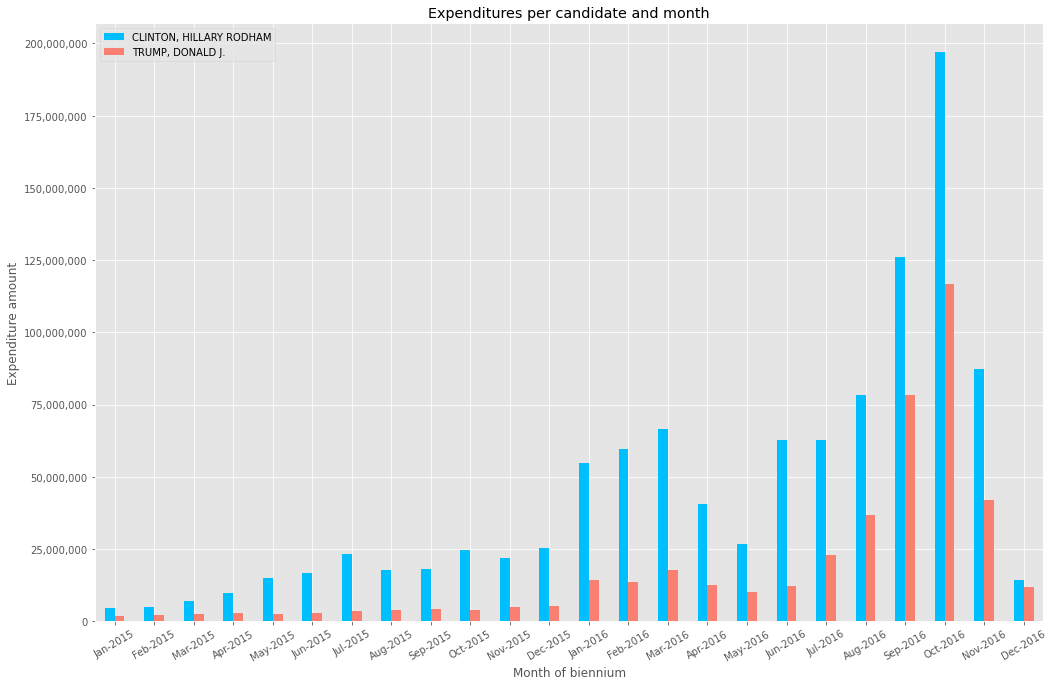

In [69]:
ax2 = exp_by_dates.plot(kind='bar', color=('deepskyblue', 'salmon'), figsize=(17, 11))
plt.title('Expenditures per candidate and month')
plt.xlabel('Month of biennium')
plt.ylabel('Expenditure amount')
plt.xticks(rotation=30, horizontalalignment="center")
plt.legend(loc=2)
plt.ticklabel_format(style='plain', axis='y') #in order to show the y axis values as non scientific notations
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))) 
#adds commas to the y axis values to make them easier to read

#### Clinton's campaign expenditures and contributions
* Now we will investigate the evolution of expenditures and contributions of Clinton in the biennium
* We create a dataframe that contains both the contributions and expenditures
* We rename the columns 
* We create the barchart

In [70]:
clinton_evolution = pd.merge(exp_by_dates['CLINTON, HILLARY RODHAM'], 
               contr_by_dates['CLINTON, HILLARY RODHAM'],
                             on='TRANSACTION_DT')
clinton_evolution.rename(columns={'CLINTON, HILLARY RODHAM_x':'Expenditures',
                          'CLINTON, HILLARY RODHAM_y':'Contributions'}, 
                        inplace=True)

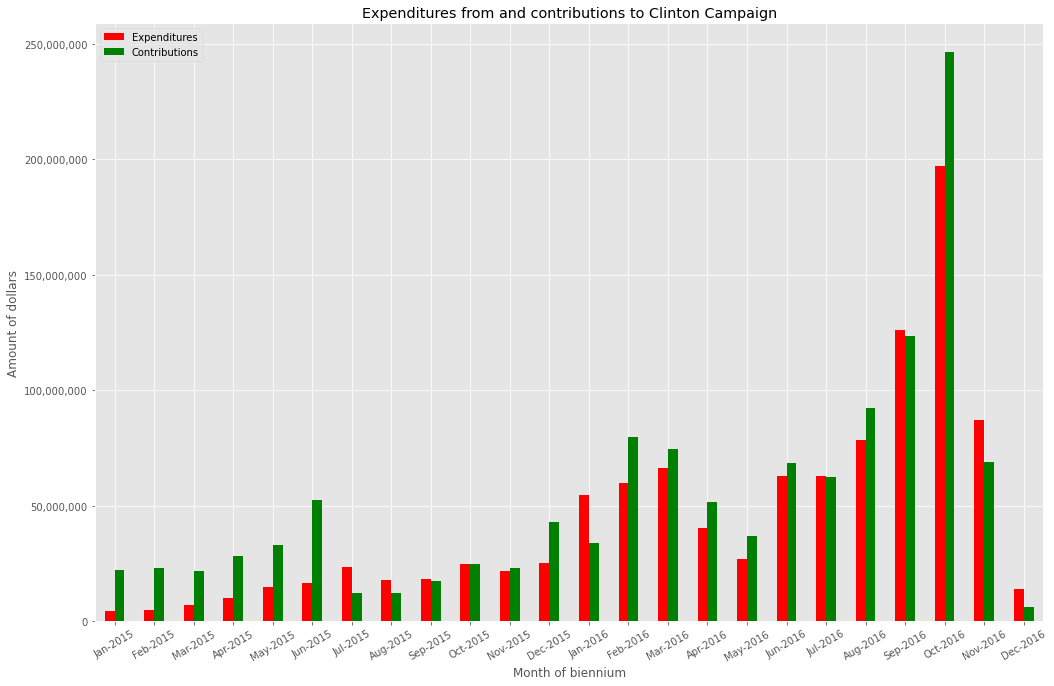

In [71]:
ax3 = clinton_evolution.plot(kind='bar', color=('red', 'green'), figsize=(17, 11))
plt.title('Expenditures from and contributions to Clinton Campaign')
plt.xlabel('Month of biennium')
plt.ylabel('Amount of dollars')
plt.xticks(rotation=30, horizontalalignment="center")
plt.legend(loc=2)
plt.ticklabel_format(style='plain', axis='y') #in order to show the y axis values as non scientific notations
ax3.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))) 
#adds commas to the y axis values to make them easier to read

#### Trump's campaign expenditures and contributions
* Now we will investigate the evolution of expenditures and contributions of Trump in the biennium
* We create a dataframe that contains both the contributions and expenditures
* We rename the columns 
* We create the barchart

In [72]:
trump_evolution = pd.merge(exp_by_dates['TRUMP, DONALD J.'], 
               contr_by_dates['TRUMP, DONALD J.'],
                             on='TRANSACTION_DT')
trump_evolution.rename(columns={'TRUMP, DONALD J._x':'Expenditures',
                          'TRUMP, DONALD J._y':'Contributions'}, 
                        inplace=True)

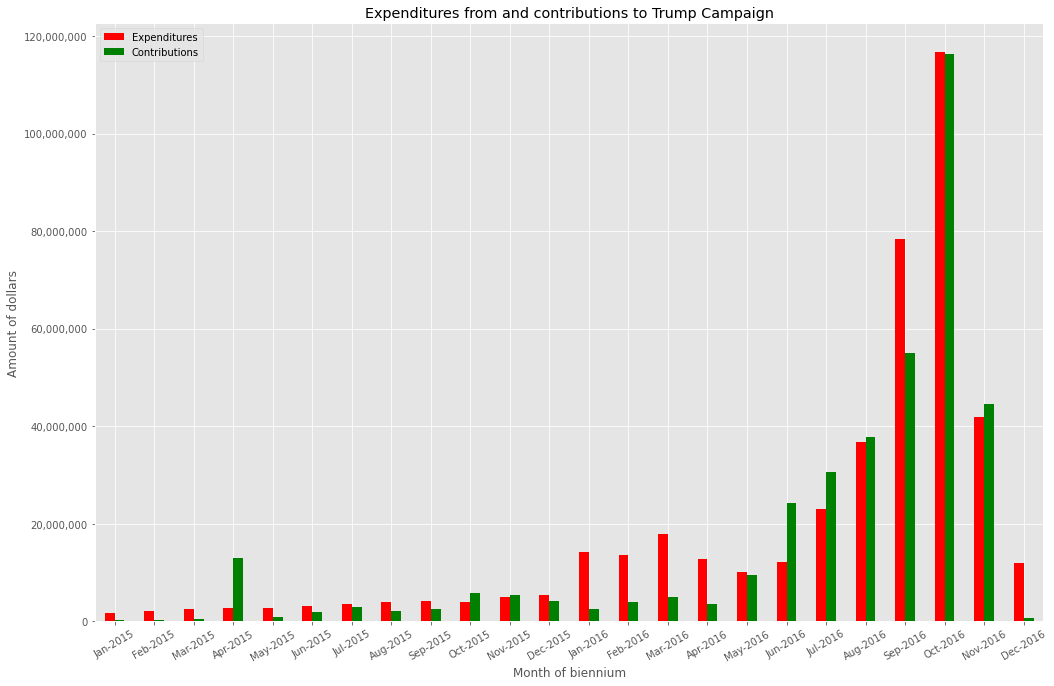

In [73]:
ax4 = trump_evolution.plot(kind='bar', color=('red', 'green'), figsize=(17, 11))
plt.title('Expenditures from and contributions to Trump Campaign')
plt.xlabel('Month of biennium')
plt.ylabel('Amount of dollars')
plt.xticks(rotation=30, horizontalalignment="center")
plt.legend(loc=2)
plt.ticklabel_format(style='plain', axis='y') #in order to show the y axis values as non scientific notations
ax4.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))) 
#adds commas to the y axis values to make them easier to read

## Question 4

* Now we will identify the biggest recipients of campaign expenditures
* To find those out, we will use the `exp` dataframe, that includes all the expenditures of Clinton and Trump for the years of 2015 and 2016
* We are going to group the expenditures by different `NAME`, getting the sum from each campaign and the amount of money they received

In [74]:
grouped_exp_name = exp[['NAME','TRANSACTION_AMT']].groupby(['NAME']).sum().\
    sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp_name.rename(columns={'TRANSACTION_AMT': 'Transaction amount'}, 
                        inplace=True)
grouped_exp_name[:10]

,Transaction amount
NAME,
GMMB,"308,463,389"
GILES-PARSCALE,"87,838,378"
AMERICAN MEDIA & ADVOCACY GROUP,"74,176,379"
AMERICAN EXPRESS,"50,604,836"
"TARGET ENTERPRISES, LLC","42,637,168"
BULLY PULPIT INTERACTIVE LLC,"42,636,611"
ADP,"34,075,801"
PRECISION NETWORK LLC,"32,124,592"
WATERFRONT STRATEGIES,"29,530,927"


We can see above the top 10 recepients of the expenditures of two campaigns when it comes to the total amount of money.
1. *GMMB*  is an advertising, political consulting and advocacy company
2. *GILES-PARSCALE*  is a professional web marketing service provider
3. *AMERICAN MEDIA & ADVOCACY GROUP* provides telecommunication services.
4. *AMERICAN EXPRESS* is a financial services company
5. *TARGET ENTERPRISES, LLC* is a media planning, media buying and media products company and so on.

* Also, in order to know the purpose that the money was spent, we will group by both `NAME` and `PURPOSE`.

In [75]:
grouped_exp_name_purpose = exp[['NAME','PURPOSE','TRANSACTION_AMT']].groupby(['NAME','PURPOSE']).sum().\
    sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp_name_purpose.rename(columns={'TRANSACTION_AMT': 'Transaction amount'}, 
                        inplace=True)
grouped_exp_name_purpose[:10]

Transaction amount
NAME                            PURPOSE                                                  
GMMB                            MEDIA BUY                                     307,782,225
GILES-PARSCALE                  DIGITAL CONSULTING/ONLINE ADVERTISING          85,336,354
AMERICAN MEDIA & ADVOCACY GROUP PLACED MEDIA                                   74,176,379
BULLY PULPIT INTERACTIVE LLC    ONLINE ADVERTISING                             31,521,463
ADP                             PAYROLL TAXES                                  28,607,969
AMERICAN EXPRESS                CREDIT CARD PAYMENT                            27,242,589
RICK REED MEDIA, INC.           PLACED MEDIA                                   24,347,840
TARGET ENTERPRISES, LLC         MEDIA PLACEMENT-SEE LINE 24                    19,020,248
                                MEDIA PLACEMENT-NOT DISSEMINATED               18,073,148
PRECISION NETWORK LLC           DIGITAL AD BUY RESERVATION                     16,032,519

#### Top recepients of the expenditures of the campaign of Trump

In [76]:
grouped_exp_name_trump = exp[['NAME','TRANSACTION_AMT']].loc[exp['CAND_SUP'] == 'TRUMP, DONALD J.'].\
        groupby(['NAME']).sum().\
        sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp_name_trump.rename(columns={'TRANSACTION_AMT': 'Transaction amount'}, 
                        inplace=True)
grouped_exp_name_trump[:10]

,Transaction amount
NAME,
GILES-PARSCALE,"87,838,378"
AMERICAN MEDIA & ADVOCACY GROUP,"74,176,379"
"RICK REED MEDIA, INC.","24,460,099"
AMERICAN EXPRESS,"19,541,119"
"ACE SPECIALTIES, LLC","15,885,324"
"PRIVATE JET SERVICES, LLC","9,953,216"
JAMESTOWN ASSOCIATES,"8,841,595"
"TAG AIR, INC.","8,741,464"
AIR CHARTER TEAM,"8,321,403"


#### Top recepients of the expenditures of the campaign of Clinton

In [77]:
grouped_exp_name_clinton = exp[['NAME','TRANSACTION_AMT']].loc[exp['CAND_SUP'] == 'CLINTON, HILLARY RODHAM'].\
        groupby(['NAME']).sum().\
        sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp_name_clinton.rename(columns={'TRANSACTION_AMT': 'Transaction amount'}, 
                        inplace=True)
grouped_exp_name_clinton[:10]

,Transaction amount
NAME,
GMMB,"308,463,389"
"TARGET ENTERPRISES, LLC","42,637,168"
BULLY PULPIT INTERACTIVE LLC,"42,636,611"
ADP,"32,572,108"
PRECISION NETWORK LLC,"32,124,592"
AMERICAN EXPRESS,"31,063,717"
WATERFRONT STRATEGIES,"29,530,927"
TARGETED PLATFORM MEDIA LLC,"29,145,852"
MARKHAM PRODUCTIONS,"16,025,852"


## Question 5

Lastly, we need to find the expenditures per voter for each state.
We start off by calculating the sum expenditures of the two presidential campaigns at each state

In [78]:
grouped_exp_state = exp[['STATE','CAND_SUP','TRANSACTION_AMT',]].groupby(['STATE','CAND_SUP']).sum().\
    sort_values(by='TRANSACTION_AMT', ascending=False)
grouped_exp_state = grouped_exp_state.reset_index()
grouped_exp_state.rename(columns={'STATE' : 'CODE'},
                        inplace=True)
grouped_exp_state

,CODE,CAND_SUP,TRANSACTION_AMT
0,DC,"CLINTON, HILLARY RODHAM","520,561,300"
1,VA,"TRUMP, DONALD J.","131,883,139"
2,NY,"CLINTON, HILLARY RODHAM","103,210,671"
3,TX,"TRUMP, DONALD J.","98,361,048"
4,CA,"CLINTON, HILLARY RODHAM","84,302,387"
...,...,...,...
115,AS,"TRUMP, DONALD J.",255
116,TC,"TRUMP, DONALD J.",207
117,G3,"CLINTON, HILLARY RODHAM",143
118,AU,"TRUMP, DONALD J.",50


Now we have to find the number of registered voters per state for the November of 2016
* After a search in the internet, we find the [KFF website](https://www.kff.org/other/state-indicator/number-of-voters-and-voter-registration-in-thousands-as-a-share-of-the-voter-population/?currentTimeframe=1&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)
* Then we download the raw data by clicking on the rop right icon (over the table), next to `Tools` on the website
* After that, we move the downloaded file `raw_data.csv` to the same folder as this notebook
* Now we can read the csv file

In [79]:
voters_state = pd.read_csv('raw_data.csv', 
                  sep=",", 
                  index_col=False,
                  skiprows=2)
voters_state.head(5)

,Location,Number of Registered Voters (in thousands),Registered Voters as a Share of the Voter Population,Number of Individuals who Voted (in thousands),Individuals who Voted as a Share of the Voter Population
0,United States,"157,596",1,"137,537",1
1,Alabama,"2,526",1,"2,095",1
2,Alaska,358,1,308,1
3,Arizona,"3,145",1,"2,769",1
4,Arkansas,"1,456",1,"1,241",1


* We rename the first column to `STATE` and the second column to  `REGISTERED_VOTERS`

In [80]:
voters_state.rename(columns={'Number of Registered Voters (in thousands)':'REGISTERED_VOTERS'
                        , 'Location' : 'STATE'},
                        inplace=True)

* We drop the other columns as they are not needed

In [81]:
voters_state = voters_state[['STATE','REGISTERED_VOTERS']]

* We also drop the first row and last 6 rows, as they have non relevant infos

In [82]:
voters_state = voters_state.drop([0,9,52,53,54,55,56,57])

* We multiply with a thousand in order to get the exact number of registered voters

In [83]:
voters_state['REGISTERED_VOTERS'] = voters_state['REGISTERED_VOTERS']*1000

* Now we have to find a table that has both the names of the states and their codes
* We find that at https://docs.omnisci.com/v4.1.1/3_apdx_states.html
* We use Beautifulsoup to get it

In [84]:
import requests
from bs4 import BeautifulSoup

try:
    r = requests.get("https://docs.omnisci.com/v4.1.1/3_apdx_states.html")
except requests.exceptions.RequestException as rex:
    print(rex)
else:
    print("Page retrieval OK")

Page retrieval OK


* Now we read the html code
* We find the table first. Then we read each line and save in a list the name of the state and its code

In [85]:
html = r.content
states_site = BeautifulSoup(html, 'html.parser')
states_list = []
table = states_site.find( "table", { "class": "colwidths-given docutils"})
for row in table.find_all('tr'):
    state_name= row.findNext('td')
    state_ab= state_name.findNext('td')
    states_list.append([state_name.get_text() , state_ab.get_text()])
states_codes = pd.DataFrame(states_list, columns=["STATE", "CODE"]) #creating dataframe
print(states_codes)

                   STATE CODE
0                Alabama   AL
1                Alabama   AL
2                 Alaska   AK
3                Arizona   AZ
4               Arkansas   AR
5             California   CA
6               Colorado   CO
7            Connecticut   CT
8               Delaware   DE
9   District of Columbia   DC
10               Florida   FL
11               Georgia   GA
12                Hawaii   HI
13                 Idaho   ID
14              Illinois   IL
15               Indiana   IN
16                  Iowa   IA
17                Kansas   KS
18              Kentucky   KY
19             Louisiana   LA
20                 Maine   ME
21              Maryland   MD
22         Massachusetts   MA
23              Michigan   MI
24             Minnesota   MN
25           Mississippi   MS
26              Missouri   MO
27               Montana   MT
28              Nebraska   NE
29                Nevada   NV
30         New Hampshire   NH
31            New Jersey   NJ
32        

* We see that `'Alabama'` is written twice. That's why we clear our data from duplicate values

In [86]:
states_codes = states_codes.drop_duplicates()

* Now we can merge the information of the registered voters per state `voters_state` with the codes of the states `states_codes`

In [87]:
voters_state = pd.merge(voters_state, 
               states_codes[['STATE','CODE']], 
               on='STATE',
               how='inner')
voters_state.sample(5)

,STATE,REGISTERED_VOTERS,CODE
6,Connecticut,"1,763,000",CT
46,Washington,"3,906,000",WA
48,Wisconsin,"3,323,000",WI
20,Massachusetts,"3,660,000",MA
37,Pennsylvania,"6,909,000",PA


* Now we will find the campaign expenditures per voter for every state. In order to do that, we start by merging the tables `voters_state` and `grouped_exp_state`

In [88]:
exp_per_voter_state = pd.merge(grouped_exp_state, 
               voters_state[['STATE','CODE','REGISTERED_VOTERS']], 
               on='CODE',
               how='inner')
exp_per_voter_state

,CODE,CAND_SUP,TRANSACTION_AMT,STATE,REGISTERED_VOTERS
0,VA,"TRUMP, DONALD J.","131,883,139",Virginia,"4,399,000"
1,VA,"CLINTON, HILLARY RODHAM","42,831,995",Virginia,"4,399,000"
2,NY,"CLINTON, HILLARY RODHAM","103,210,671",New York,"9,142,000"
3,NY,"TRUMP, DONALD J.","28,170,871",New York,"9,142,000"
4,TX,"TRUMP, DONALD J.","98,361,048",Texas,"11,724,000"
...,...,...,...,...,...
95,VT,"TRUMP, DONALD J.","81,468",Vermont,"351,000"
96,ID,"TRUMP, DONALD J.","83,550",Idaho,"790,000"
97,ID,"CLINTON, HILLARY RODHAM","29,787",Idaho,"790,000"
98,HI,"CLINTON, HILLARY RODHAM","63,833",Hawaii,"530,000"


* Now we just have to divide the column `TRANSACTION_AMT` with the column `REGISTERED_VOTERS` for each line

In [89]:
exp_per_voter_state['AMT_PERVOTER'] = exp_per_voter_state['TRANSACTION_AMT'] / exp_per_voter_state['REGISTERED_VOTERS']

* We fix the format so that it includes 2 decimal places
* Also, we sort the table by decreasing amount of expenditure per voter `AMT_PERVOTER`

In [90]:
pd.options.display.float_format = '{:,.2f}'.format
exp_per_voter_state = exp_per_voter_state.sort_values(by='AMT_PERVOTER', ascending=True)

* Now we will find the swingstates from the website of https://constitutioncenter.org/blog/what-are-the-really-swing-states-in-the-2016-election/

In [91]:
try:
    r = requests.get("https://constitutioncenter.org/blog/what-are-the-really-swing-states-in-the-2016-election/")
except requests.exceptions.RequestException as rex:
    print(rex)
else:
    print("Page retrieval OK")

Page retrieval OK


We see that all the swing states are underlined so we select them by using `find_all('u')`

In [92]:
html = r.content
swingstates_site = BeautifulSoup(html, 'html.parser')
swing_states_list = []
i = 0 #counter
for underlined in swingstates_site.find_all('u'):
    swing_states_list.append(underlined.get_text())
    i = i + 1
    if (i == 11):
        break #we only want the 11 definite swing states
print(swing_states_list)

['Colorado', 'Florida', 'Iowa', 'Michigan', 'Minnesota ', 'Nevada ', 'New Hampshire ', 'North Carolina', 'Ohio ', 'Pennsylvania', 'Virginia']


* Now we create a dataframe with all the swingstates and we create a column called `SWING_STATE` which takes the value `'True'`

In [93]:
swing_states = pd.DataFrame(swing_states_list, columns=["STATE"])
swing_states['SWING_STATE'] = True
print(swing_states)

             STATE  SWING_STATE
0         Colorado         True
1          Florida         True
2             Iowa         True
3         Michigan         True
4       Minnesota          True
5          Nevada          True
6   New Hampshire          True
7   North Carolina         True
8            Ohio          True
9     Pennsylvania         True
10        Virginia         True


* However we see that some names of the column `STATE` contain spaces, e.g. Minnesota
* Thus we fix the names of the values 

In [94]:
names_mapping = {'Minnesota ':'Minnesota',
                        'Nevada ':'Nevada',
                        'New Hampshire ':'New Hampshire',
                        'Ohio ': 'Ohio'}
# If no mapping provided, return x
f = lambda x: names_mapping.get(x, x) 
swing_states.loc[:, 'STATE'] = swing_states.loc[:, 'STATE'].map(f)   

* Now we merge the tables `exp_per_voter_state` and `swing_states`

In [95]:
exp_per_voter_state = pd.merge(exp_per_voter_state, 
               swing_states, 
               on='STATE',
               how='left')

* We fill all NaN values of `SWING_STATE` with `'False'`

In [96]:
exp_per_voter_state['SWING_STATE'] = exp_per_voter_state['SWING_STATE'].fillna(False)

#### Swing-states examination
* Now we investigate the expenditures per registered voter for each of the swing-states
* We use seaborn and a barplot to showcase it

Text(0.5, 0, 'Expenditure amount per registered voter ($)')

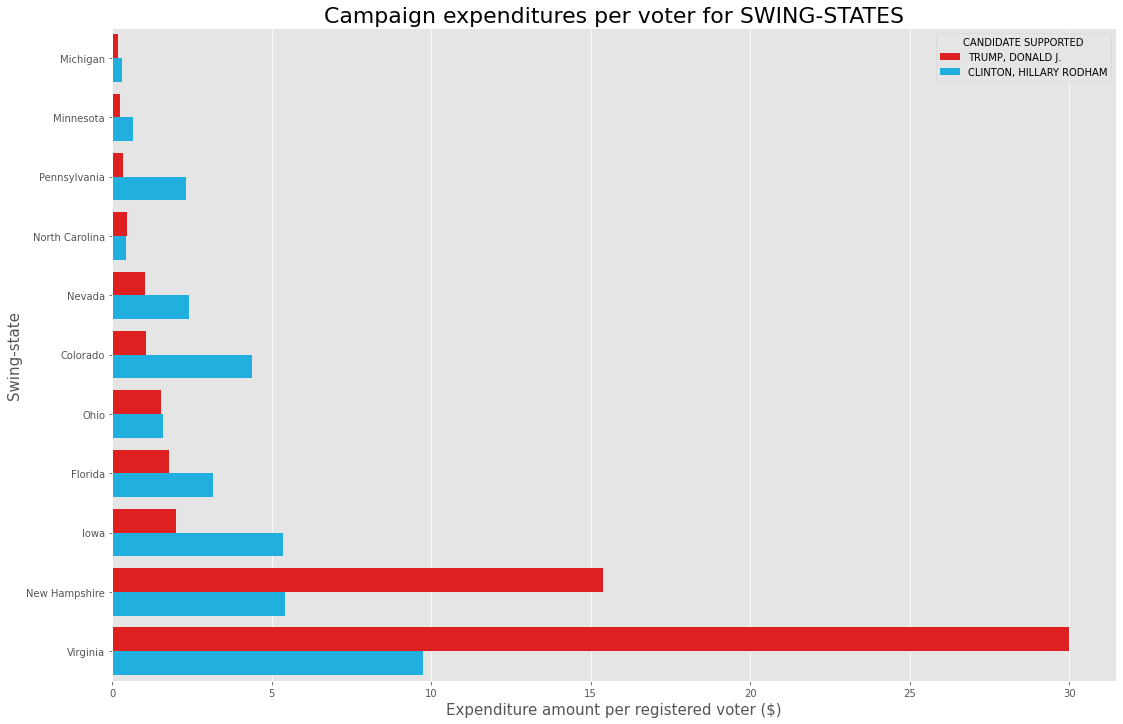

In [97]:
fig_dims = (18, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='AMT_PERVOTER', y='STATE', hue='CAND_SUP', palette=('red', 'deepskyblue'),
            data=exp_per_voter_state.loc[exp_per_voter_state['SWING_STATE']])
plt.legend(title='CANDIDATE SUPPORTED')
plt.title('Campaign expenditures per voter for SWING-STATES', fontdict ={'size': 22})
plt.ylabel('Swing-state', fontdict ={'size': 15})
plt.xlabel('Expenditure amount per registered voter ($)',fontdict ={'size': 15})

Conclusions:
* It is visible that for the states of Virginia and New Hampshire, Trump spent more than 3 times the money per registered voter that Clinton did.
* Also, we can see that for the states of Pennsylvania, Minnesota, Colorado, Iowa and Nevada, Clinton spent significally more money per registered voter that Trump did (more than double in most cases)
* In the other swing states, the expenditures per voter are more matching when it comes to the two campaigns

#### Non swing-states examination
* Now we investigate the expenditures per registered voter for each of the non swing-states
* We use seaborn and a barplot to showcase it

Text(0.5, 0, 'Expenditure amount per registered voter ($)')

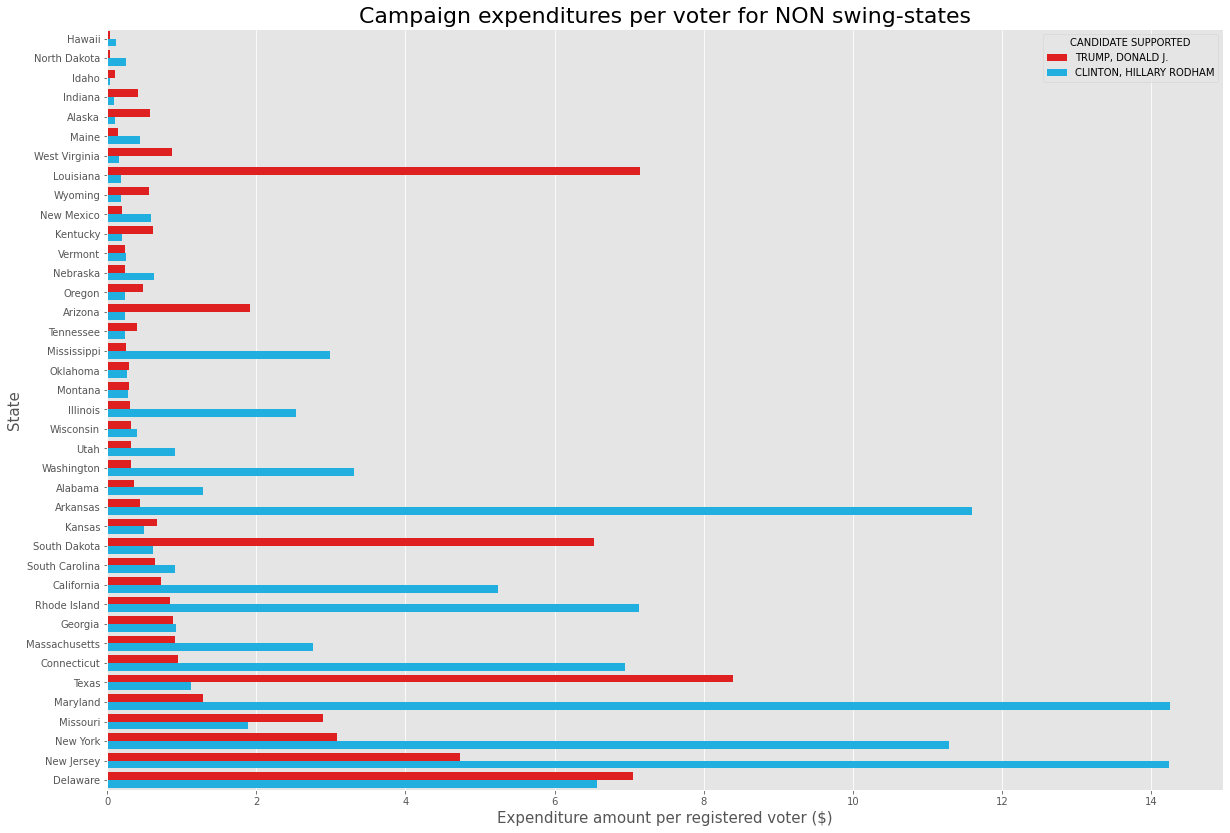

In [98]:
fig_dims = (20, 14)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='AMT_PERVOTER', y='STATE', hue='CAND_SUP', palette=('red', 'deepskyblue'),
            data=exp_per_voter_state.loc[~(exp_per_voter_state['SWING_STATE'])])
plt.legend(title='CANDIDATE SUPPORTED')
plt.title('Campaign expenditures per voter for NON swing-states', fontdict ={'size': 22})
plt.ylabel('State', fontdict ={'size': 15})
plt.xlabel('Expenditure amount per registered voter ($)',fontdict ={'size': 15})

Conclusion:
It is visible that there is huge contrast on the expenditures per voter in most of states. In detail, for most of those states one campaign is ahead of the other in expenditures per voter with a huge deficit.

* We group the previous data by all states , ignoring the campaigns
* We create a barchart for each state
* We can identify a swingstate with the olive color

In [99]:
total_exp_state_voter = exp_per_voter_state[['STATE','AMT_PERVOTER','SWING_STATE']].groupby(['STATE']).sum().\
    sort_values(by='AMT_PERVOTER', ascending=True)
total_exp_state_voter = total_exp_state_voter.reset_index()
total_exp_state_voter['SWING_STATE'] = np.where((total_exp_state_voter['SWING_STATE'] == 2), 
                True, False)#fixing the column SWING_STATE

Text(0.5, 1.0, 'Campaign expenditures per voter for each state')

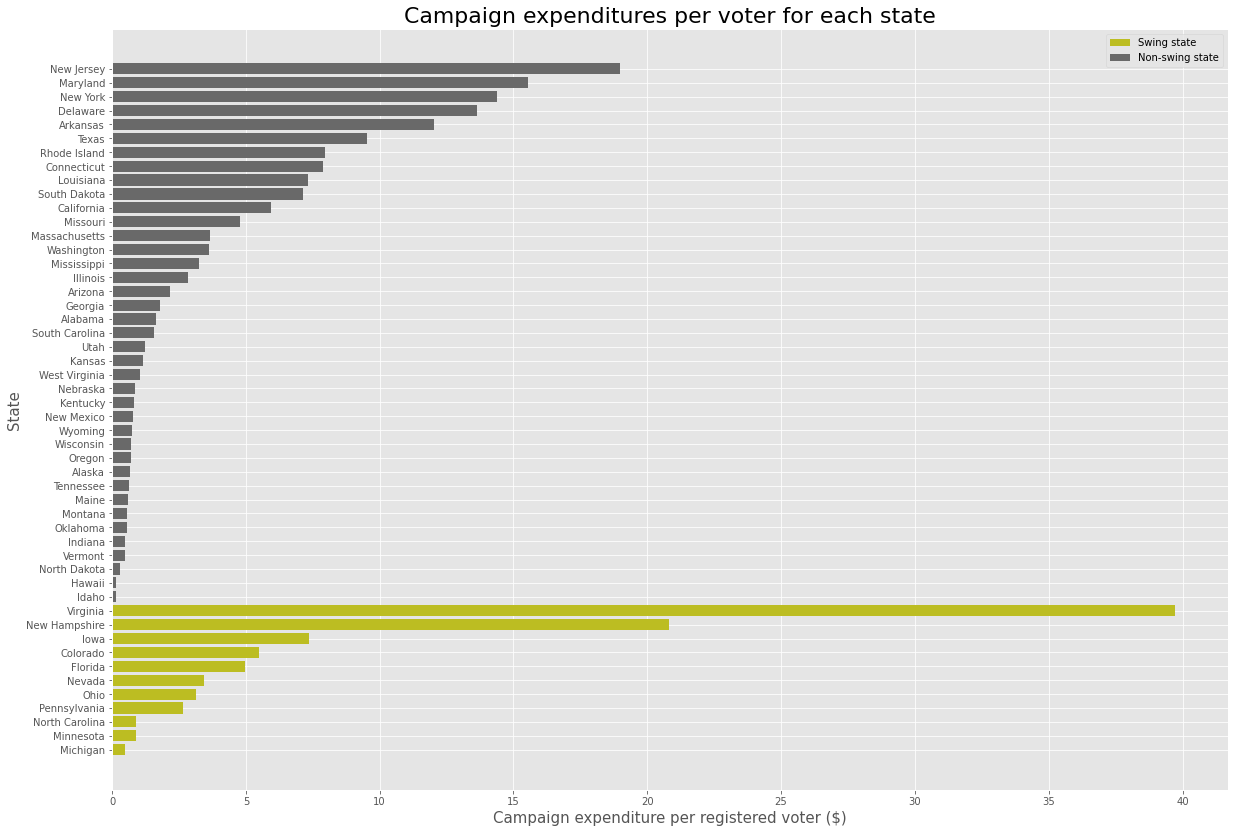

In [100]:
#saving all the names of the swing states in a different dataframe
states_swing = total_exp_state_voter.loc[total_exp_state_voter['SWING_STATE']]['STATE']
#saving all the expenditures per voter of every swing states in a different dataframe
amt_swing = total_exp_state_voter.loc[total_exp_state_voter['SWING_STATE']]['AMT_PERVOTER']
plt.figure(figsize=(20,14))
plt.barh(states_swing , amt_swing, color='tab:olive', label='Swing state')

#saving all the names of the non-swing states in a different dataframe
states_normal = total_exp_state_voter.loc[~(total_exp_state_voter['SWING_STATE'])]['STATE']
#saving all the expenditures per voter of every nonswing states in a different dataframe
amt_normal = total_exp_state_voter.loc[~(total_exp_state_voter['SWING_STATE'])]['AMT_PERVOTER']
plt.barh(states_normal , amt_normal, color='dimgrey', label ='Non-swing state')
plt.legend(loc=1) #fixing legend
plt.ylabel('State', fontdict ={'size': 15})
plt.xlabel('Campaign expenditure per registered voter ($)',fontdict ={'size': 15})
plt.title('Campaign expenditures per voter for each state', fontdict ={'size': 22})

Looking at the chart, we can see that one swing-state (the top olive bar) has much more expenditures per voter compared to any other state. However, we also see that some other swing-states (the other olive ones except the first and second) have more balanced expenditures per voter. Lastly, the non swing-states seem to have all kind of values for the expenditures per voter

* Lastly, we examine a boxplot to see the outliers and the medians

In [101]:
total_exp_state_voter['SWING_STATE'] = np.where((total_exp_state_voter['SWING_STATE']), 
                'Swing-state', 'Regular-state')#fixing the column SWING_STATE

Text(0.5, 1.0, 'Campaign expenditures for swing and non swing states boxplot')

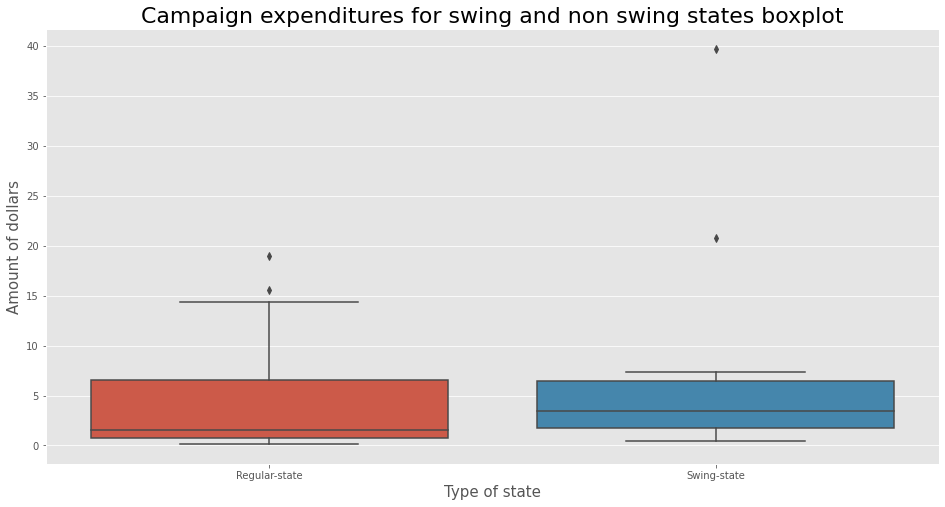

In [102]:
plt.figure(figsize=(16,8))
sns.boxplot(x="SWING_STATE", y="AMT_PERVOTER" , data=total_exp_state_voter)
plt.ylabel('Amount of dollars', fontdict ={'size': 15})
plt.xlabel('Type of state',fontdict ={'size': 15})
plt.title('Campaign expenditures for swing and non swing states boxplot', fontdict ={'size': 22})

We see that the median campaign expenditures for swing states is around twice as much as the median campaign expenditures for regular states